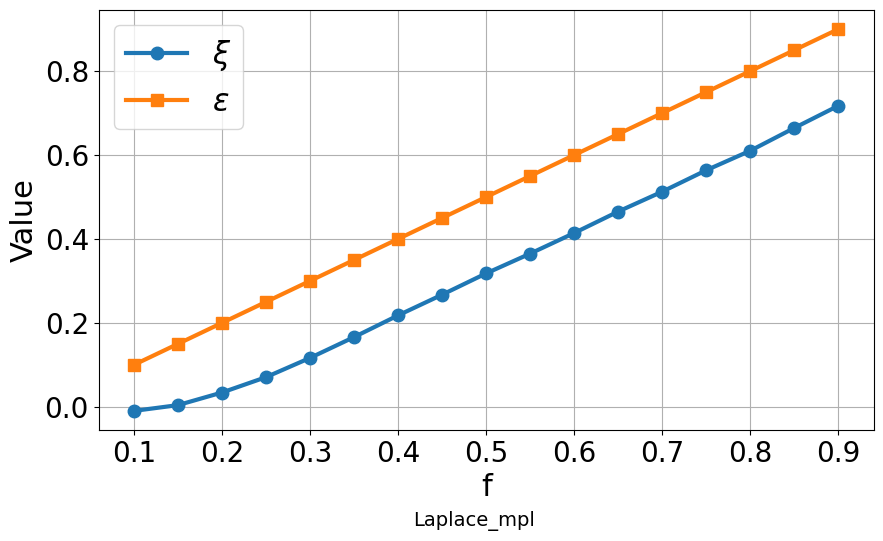

In [1]:
import numpy as np
from scipy.stats import laplace, norm
from scipy.optimize import root_scalar
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d

# Fill adjacent data sets
B = 10 # Dimension of input parameters
x_mat = np.zeros(B)
x_prime_mat = np.zeros(B)
for b in range(B):
    x_mat[b] = 1
    x_prime_mat[b] = 1 + (b + 1) / B


# These functions are used to calculate the true privacy parameter
def hyp_distance_max(scal_par):
    m_1 = 2
    m_2 = 1
    out = scal_par * (max(m_1, m_2) - min(m_1, m_2)) + np.log(2 - np.exp(
        -scal_par * max(m_1, m_2))) - np.log(2 -
                                             np.exp(-scal_par * min(m_1, m_2)))
    return out


def inverse(f, lower=-100, upper=100):

    def func(y):
        return root_scalar(lambda x: f(x) - y, bracket=[lower, upper]).root

    return func


hyp_inverse = inverse(hyp_distance_max, 0, 10)


def _identity(x):
    return x.item(0)


class LaplaceMechanism():

    def __init__(self, fun=_identity, eps: float = 0.1):
        """
        Create a Laplace mechanism.

        Args:
            fun: The function performed before adding noise. The function must accept a 1d array and produce a scalar.
            eps: target epsilon
        """
        self.fun = fun
        self.scale = 1.0 / eps

    def m(self, a, n_samples: int = 1):
        loc = self.fun(a)
        result = np.random.laplace(loc=loc, scale=self.scale, size=n_samples)
        return result

# MPL
def MPL(epsilon):
    global delta
    eps_vec = np.zeros(B)
    t_vec = np.zeros(B)
    h_est = 0

    for b in range(B):
        privacy_mechanism = LaplaceMechanism(eps=epsilon)
        X = np.array(privacy_mechanism.m(a=x_mat[b], n_samples=n))
        Y = np.array(privacy_mechanism.m(a=x_prime_mat[b], n_samples=n))

        kdX = KernelDensity(bandwidth=1.06 * np.std(X) * (n**(-1 / 5))).fit(
            X.reshape(-1, 1))
        kdY = KernelDensity(bandwidth=1.06 * np.std(Y) * (n**(-1 / 5))).fit(
            Y.reshape(-1, 1))

        h_est += (kdX.bandwidth_ + kdY.bandwidth_) / 2

        log_X = kdX.score_samples(C_discr.reshape(-1, 1))
        log_X[log_X < np.log(delta)] = 0
        log_Y = kdY.score_samples(C_discr.reshape(-1, 1))
        log_Y[log_Y < np.log(delta)] = 0

        log_difference = np.abs(log_X - log_Y)
        hat_eps = np.max(log_difference)
        hat_t = np.argmax(log_difference)
        eps_vec[b] = hat_eps
        t_vec[b] = hat_t

    h_est = h_est / B
    b_star = np.argmax(eps_vec)
    t_max = t_vec[b_star] / (len(C_discr) - 1) * glob + C[0]

    h_max = (h_est)**(1 + tune)
    delta = 1e-10
    X = np.array(privacy_mechanism.m(a=x_mat[b_star], n_samples=N))
    Y = np.array(privacy_mechanism.m(a=x_prime_mat[b_star], n_samples=N))

    kdX_star = KernelDensity(bandwidth=h_max).fit(X.reshape(-1, 1))
    kdY_star = KernelDensity(bandwidth=h_max).fit(Y.reshape(-1, 1))

    hat_ell_star = np.abs(
        np.log(
            np.exp(kdX_star.score_samples(np.array([t_max]).reshape(-1, 1)))
            [0]) - np.log(
                np.exp(kdY_star.score_samples(
                    np.array([t_max]).reshape(-1, 1)))[0]))
    c_N = np.sqrt(N * kdX_star.bandwidth_)
    hat_sigma = np.sqrt(
        1 / (2 * np.sqrt(np.pi)) *
        (1 / np.exp(kdX_star.score_samples(np.array([t_max]).reshape(
            -1, 1)))[0] + 1 /
         np.exp(kdY_star.score_samples(np.array([t_max]).reshape(-1, 1)))[0]))

    LB = norm.ppf(alpha) * hat_sigma / c_N + hat_ell_star

    return LB


# Inputs
C = np.array([0, 2])
glob = C[1] - C[0]
C_discr = np.linspace(C[0], C[1], num=21)
n = 20000
N = 50000
delta = 0.001
tune = 0.15
alpha = 0.05



reps = 100

f_values = np.arange(0.1, 0.95, 0.05)
epslion_star = np.zeros_like(f_values)
xi_hat = np.zeros_like(f_values)
epsilon = np.zeros_like(f_values)

for i, f in enumerate(f_values):
    epslion_star[i] = f
    epsilon[i] = hyp_inverse(f)
    A = Parallel(n_jobs=7)(delayed(MPL)(epsilon[i]) for _ in range(reps))
    final_array = np.array(A)
    xi_hat[i] = sum(final_array) / len(final_array)

plt.figure(figsize=(10, 6))
plt.subplots_adjust(bottom=0.18)

# print the first line
plt.plot(f_values, xi_hat, marker='o', markersize=9,linewidth=3,label=r'$\xi$')

# print the second line
plt.plot(f_values, epslion_star, marker='s',markersize=9, linewidth=3,label=r'$\epsilon$')




plt.xlabel('f', fontsize=22)
plt.ylabel('Value', fontsize=22)
plt.xticks(fontsize=20)  
plt.yticks(fontsize=20)  
plt.legend(fontsize=22)
plt.grid(True)

# gcf: Get Current Figure
fig=plt.gcf()
fig.text(0.5, 0.02, 'Laplace_mpl', ha='center', fontsize=14)
fig.savefig('laplace.svg',format='svg')


